# Extraction of One spectrum
=============================================

- Creation : Tuesday 2016 June 14th
- Author Sylvie Dagoret-Campagne 
- affiliation : LAL/IN2P3/CNRS

Raw Spectrum of HD158485


## 1) Import package

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits

import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [2]:
from scipy import stats 
from scipy import ndimage
import os
from datetime import datetime, timedelta

In [3]:
import libMonocamBaseImages           # my tool library written to do that CCD reduction

In [4]:
now=datetime.utcnow()  # choose UTC time
datestr=str(now)
print 'standard date format for the analysis :',datestr
#  want the following format '2016-05-10T11:55:27.267'
date_of_analysis=now.strftime('%Y-%m-%dT%H:%M:%S')
print 'fits date format for the analysis : ',date_of_analysis

standard date format for the analysis : 2016-07-01 20:07:35.328045
fits date format for the analysis :  2016-07-01T20:07:35


In [5]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.background import Background2D

## Few Definition

In [6]:
object_name='HD158485_grat_120'

In [7]:
path='./HD158485_grat'
basefilename='AssScImHD158485_grat_120.fits' # check master bias
filename=os.path.join(path,basefilename)
outputfigfilename='ScienceImageAssemblerInput_img.pdf'
outputfigfilename2='ReorderedImage_'+object_name+'_img.pdf'
outputfigfilename3='SingleImage_'+object_name+'_img.pdf'
outputfigfilename4='RotatedImage_'+object_name+'_img.pdf'
outputfigfilename5='SpectrumRegion_'+object_name+'_img.pdf'
outputfigfilename6='SpectrumHisto_'+object_name+'_img.pdf'
outputfigfilename7='SpectrumLogHisto_'+object_name+'_img.pdf'

## Analysis Selection

In [8]:
BackgroundSubtractionFlag=False

## 4) Read the images

In [136]:
allimages = []
ccd_chan = ccdproc.CCDData.read(filename, hdu=0,unit='adu') 
allimages.append(ccd_chan)

## 5) Shows the images

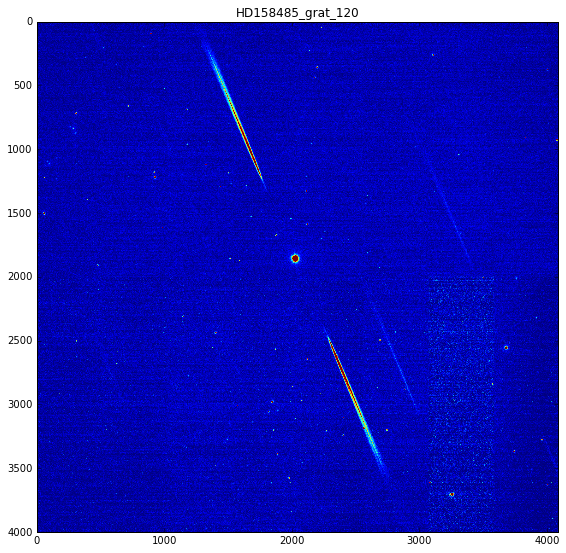

In [137]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(ccd_chan,vmin=0,vmax=50.)
plt.title(object_name)
plt.tight_layout()
plt.savefig(outputfigfilename3)

## Background subtraction

The user should decide if the background must be subtracted or not

In [138]:
if BackgroundSubtractionFlag:
    bkg = Background2D(ccd_chan, (100, 100), filter_size=(3, 3),method='median')
    data=ccd_chan - bkg.background
    print('median background = ',bkg.background_median)
    print('median rms = ',bkg.background_rms_median)
else:
    data=ccd_chan

This calculation of sky background has to be used to erase the central star

In [139]:
skybackground=np.median(data)
sigma_skybackground=np.std(data)

In [15]:
print 'remaing sky background = {:2.3f} +/- {:2.3f}'.format(skybackground,sigma_skybackground)

remaing sky background = 2.121 +/- 62.998


## 8.) Image rotation and spectrum region selection

In [76]:
rotation_angle_test=np.linspace(67.0,67.5,100)

In [77]:
NBTESTS=rotation_angle_test.shape[0]

### Optimisation to find the best rotation angle

In [18]:
flux=np.zeros(NBTESTS)

In [127]:
w=10 # spectrum width selection
ws=75 # star width

In [20]:
for index,angle in np.ndenumerate(rotation_angle_test):
    rotated_image=ndimage.interpolation.rotate(data,angle)
    imax,jmax = np.unravel_index(rotated_image.argmax(), rotated_image.shape)
    region=rotated_image[imax-w: imax+w,480:4830]  # extract the region
    imax2,jmax2 = np.unravel_index(region.argmax(), region.shape)
    region[:,jmax2-ws:jmax2+ws]=skybackground  # suppress central star
    flux[index]=region.sum()
    print 'index = {} angle={:2.4f} flux = {:2.0f}'.format(index,angle,flux[index])

index = (0,) angle=67.0000 flux = 1447588
index = (1,) angle=67.0051 flux = 1452479
index = (2,) angle=67.0101 flux = 1457281
index = (3,) angle=67.0152 flux = 1501693
index = (4,) angle=67.0202 flux = 1505991
index = (5,) angle=67.0253 flux = 1525389
index = (6,) angle=67.0303 flux = 1529904
index = (7,) angle=67.0354 flux = 1534281
index = (8,) angle=67.0404 flux = 1529343
index = (9,) angle=67.0455 flux = 1533074
index = (10,) angle=67.0505 flux = 1536709
index = (11,) angle=67.0556 flux = 1540251
index = (12,) angle=67.0606 flux = 1543690
index = (13,) angle=67.0657 flux = 1547013
index = (14,) angle=67.0707 flux = 1542542
index = (15,) angle=67.0758 flux = 1564927
index = (16,) angle=67.0808 flux = 1568272
index = (17,) angle=67.0859 flux = 1571520
index = (18,) angle=67.0909 flux = 1574709
index = (19,) angle=67.0960 flux = 1565155
index = (20,) angle=67.1010 flux = 1567927
index = (21,) angle=67.1061 flux = 1570628
index = (22,) angle=67.1111 flux = 1573255
index = (23,) angle=6

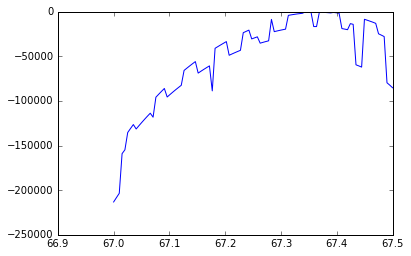

In [23]:
dflux=flux-flux.max()
plt.plot(rotation_angle_test,dflux)

In [26]:
#selected_angle=67.35353535

In [24]:
selected_angle= rotation_angle_test[np.where(flux==flux.max())]

In [25]:
print 'selected angle = {} degrees'.format(selected_angle)

selected angle = [ 67.35353535] degrees


In [140]:
rotated_image=ndimage.interpolation.rotate(data,selected_angle)

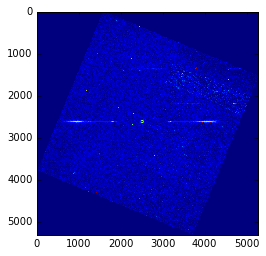

In [144]:
plt.imshow(rotated_image,vmin=0,vmax=50)

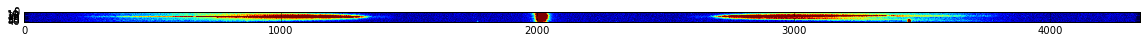

In [148]:
wcheck=20
imax,jmax = np.unravel_index(rotated_image.argmax(), rotated_image.shape)
check_region=np.copy(rotated_image[imax-wcheck: imax+wcheck,480:4830])  # extract the region
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(check_region,vmin=0,vmax=50)

### Do the rotation for the selected  angle

In [149]:
themaximum=rotated_image.max()

In [150]:
imax,jmax = np.unravel_index(rotated_image.argmax(), rotated_image.shape)
print imax,' ',jmax

2622   2493


In [151]:
np.where(rotated_image==rotated_image.max())

(array([2622]), array([2493]))

In [152]:
w=20

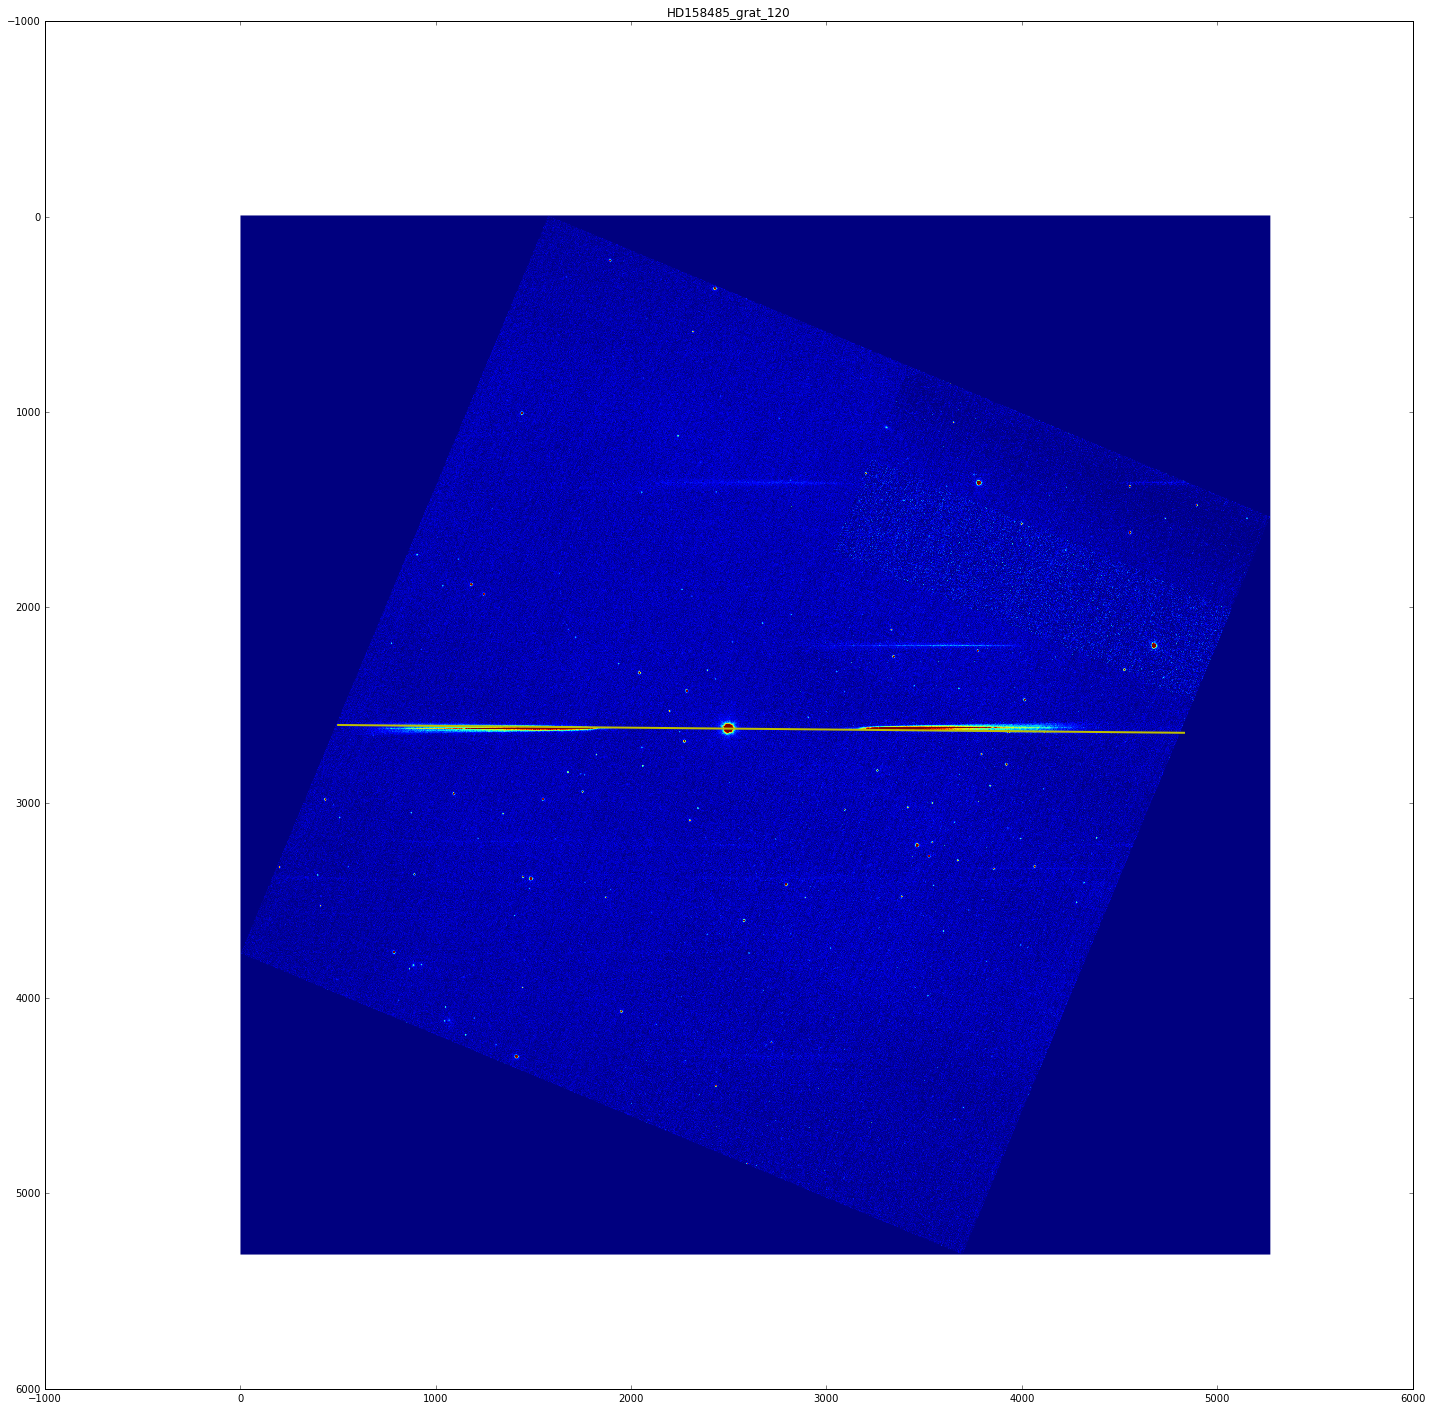

In [153]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(rotated_image,vmin=0,vmax=50.)
ax.plot([500, 4830], [imax-w, imax+w], color='y', linestyle='-', linewidth=2)
#ax.plot([500, 4830], [imax-w, imax+w], color='y', linestyle='-', linewidth=2)
plt.title(object_name)
plt.tight_layout()
plt.savefig(outputfigfilename4)

In [154]:
SpectrumRegion=rotated_image[imax-100: imax+100,480:4830]

In [155]:
SpectrumRegionNew=np.copy(SpectrumRegion)

In [156]:
imax2,jmax2 = np.unravel_index(SpectrumRegionNew.argmax(), SpectrumRegionNew.shape)
print imax2,' ',jmax2

100   2013


In [157]:
SpectrumRegionNew[:,jmax2-ws: jmax2+ws]=skybackground

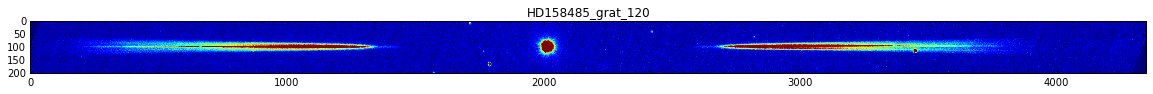

In [158]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(SpectrumRegion,vmin=0,vmax=50.)
plt.title(object_name)

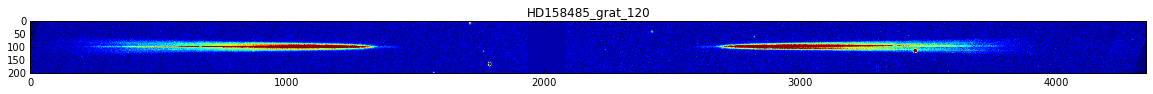

In [159]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(SpectrumRegionNew,vmin=0,vmax=50.)
plt.title(object_name)

## Optimize the width

In [160]:
widths=np.arange(5,100,1)

In [50]:
widths

array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
       56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
       73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89,
       90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [161]:
NBWIDTHS=widths.shape[0]

In [162]:
profile_list=[]
integratedflux=np.zeros(NBWIDTHS)

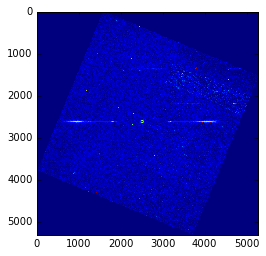

In [163]:
plt.imshow(rotated_image,vmin=0,vmax=50)

In [164]:
#imax,jmax = np.unravel_index(SpectrumRegionNew.argmax(), SpectrumRegionNew.shape)
#print imax,' ',jmax
for index,thew in np.ndenumerate(widths):
    
    TestRegion=np.copy(rotated_image[imax-thew: imax+thew,480:4830])
    imax2,jmax2 = np.unravel_index(TestRegion.argmax(), TestRegion.shape)
    TestRegion[:,jmax2-ws: jmax2+ws]=skybackground  # remove the star
    profile=np.sum(TestRegion,axis=1)
    integratedflux[index]=profile.sum()
    profile_list.append(profile)
    

In [165]:
integratedflux=integratedflux/integratedflux.max()

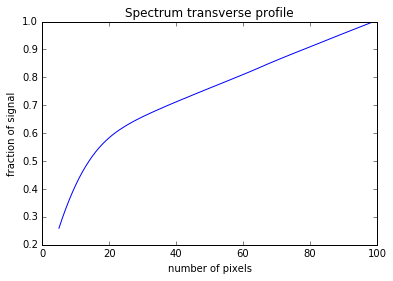

In [226]:
plt.plot(widths,integratedflux)
plt.title('Spectrum transverse profile')
plt.xlabel('number of pixels')
plt.ylabel('fraction of signal')

In [207]:
wsel=10  # should be 18, but set 10 due to the star

## 9.) Extraction of the spectrum from the image

In [215]:
imax,jmax = np.unravel_index(rotated_image.argmax(), rotated_image.shape)
print imax,' ',jmax
SelectedSpectrumRegion=np.copy(rotated_image[imax-wsel: imax+wsel,480:4830])

2622   2493


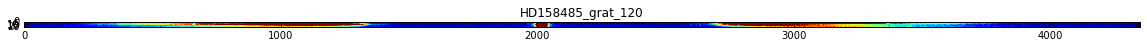

In [214]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(SelectedSpectrumRegion,vmin=0,vmax=50.)
plt.title(object_name)

In [60]:
w

10

In [216]:
imax2,jmax2 = np.unravel_index(SelectedSpectrumRegion.argmax(), SelectedSpectrumRegion.shape)
print imax2,' ',jmax2

10   2013


In [217]:
SelectedSpectrumRegion[:,jmax2-ws: jmax2+ws]=skybackground

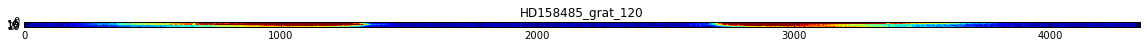

In [218]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(SelectedSpectrumRegion,vmin=0,vmax=50.)
plt.title(object_name)
#plt.tight_layout()
plt.savefig(outputfigfilename5)

In [219]:
spectrum=np.sum(SelectedSpectrumRegion,axis=0)

In [192]:
spectrum

array([ 22.15972086,  33.63527504,  36.18711813, ...,   0.        ,
         0.        ,   0.        ])

## 10.)  Plot the spectrum

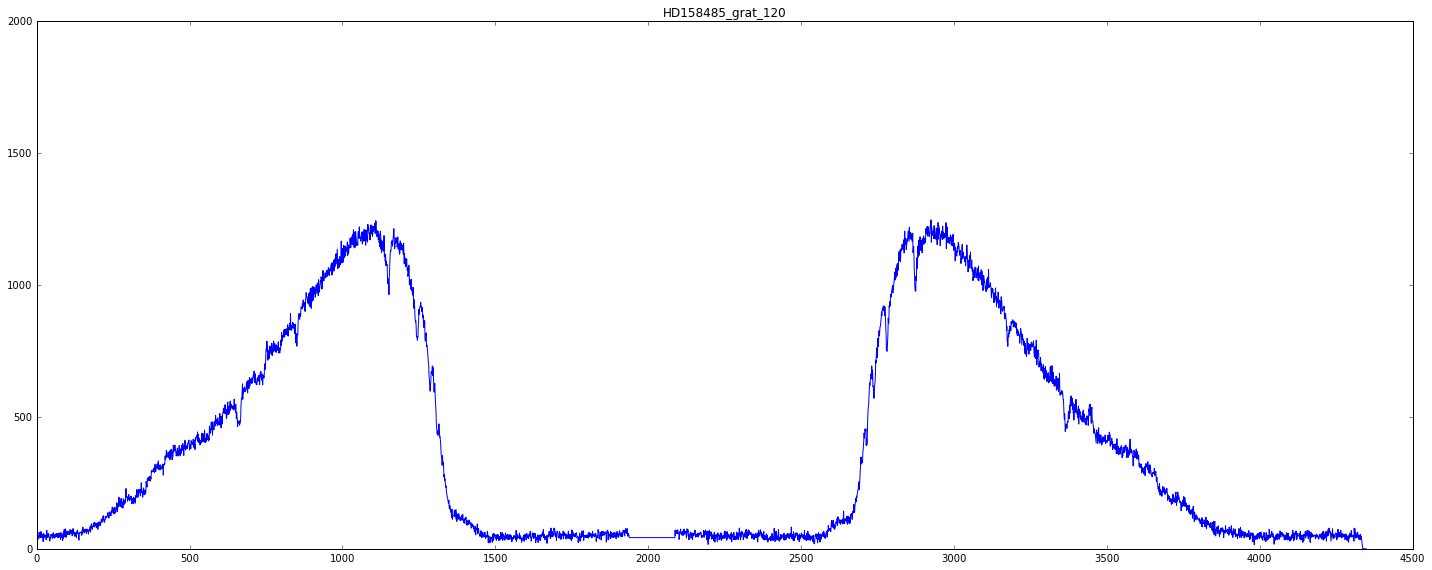

In [220]:
fig, ax = plt.subplots(figsize=(20, 8))
plt.plot(spectrum)
plt.ylim(0.,2000.)
plt.title(object_name)
plt.tight_layout()
plt.savefig(outputfigfilename6)

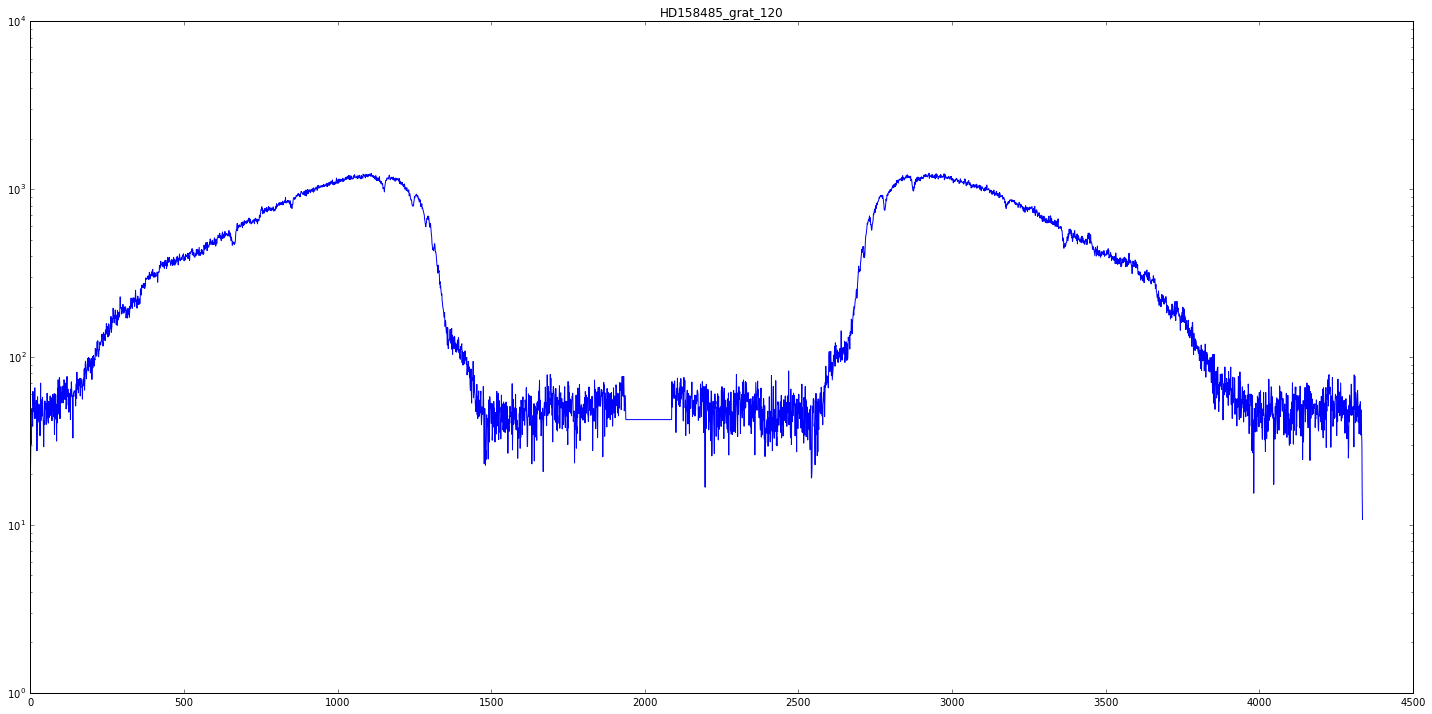

In [222]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.semilogy(spectrum)
plt.ylim(1.,10000.)
plt.title(object_name)
plt.tight_layout()
plt.savefig(outputfigfilename7)